## Neural Network from scratch
by [Dino Persson](https://www.youtube.com/channel/UCkzW5JSFwvKRjXABI-UTAkQ)

For more complex data, we can't always rely on linear regression or other simple models and need a more powerful one. A neural network with a softmax classifier which we're going to implement in this notebook, is about equivalent to a SVM and as we will see it has the ability to fit quite complex looking data. Making a neural network from scratch can be quite a difficult process as you need to understand several steps, backward propogation perhaps being the most difficult one. To this notebook I have a *VIDEO* where I go through the derivation for the backprop calculations made in this neural network.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Generate data

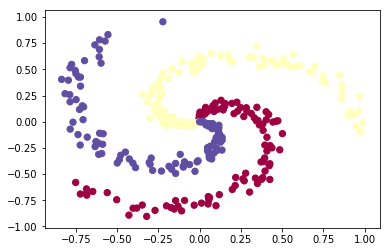

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [3]:
print(f'X has shape {X.shape} in the first column it has X positions, second column the y values')
print(f'y has shape {y.shape} and has values of what class each point in X belong to')

X has shape (300, 2) in the first column it has X positions, second column the y values
y has shape (300,) and has values of what class each point in X belong to


### Create our Neural Network

In [4]:
class NeuralNetwork(object):
    
    def __init__(self):
        # m for training examples (or how many points)
        self.m = X.shape[0]
        # n for number of features
        self.n = X.shape[1]
        # K for the number of outputs in the last layer (number of classes)
        self.h2 = K
        # h1 for size of first hidden layer
        self.h1 = 25
        #parameter lambd (lambda is keyword in Python) for l2 regularization
        self.lambd = 1e-3
        #learning_rate
        self.learning_rate = 1e-0

    def initalize_he_weights(self, l0, l1):
        # send in previous layer size l0 and next layer size l1 and returns he initialized weights
        w = np.random.randn(l0, l1) * np.sqrt(2. / l0)
        b = np.zeros((1, l1))
        
        return w, b
    
    def forward_prop(self, X, parameters):
        W2 = parameters['W2']
        W1 = parameters['W1']
        b2 = parameters['b2']
        b1 = parameters['b1']
        
        #forward prop
        a0 = X
        z1 = np.dot(a0,W1) + b1
        # apply nonlinearity (relu)
        a1 = np.maximum(0, z1)
        z2 = np.dot(a1, W2) + b2
        
        #softmax on the last layer
        scores = z2
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
        
        #cache values from forward pass to use for backward pass
        cache = {'a0' : X,
        'probs' : probs, 
        'a1' : a1}
        
        return cache, probs
        
    def compute_cost(self, y, probs, parameters):
        W2 = parameters['W2']
        W1 = parameters['W1']
        # Want to only take the -np.log of our prediction of the actual class label for
        # each training example. That's why we index [np.arange(self.m), y]
        data_loss = np.sum(-np.log(probs[np.arange(self.m), y]) / self.m)
        reg_loss = 0.5* self.lambd * np.sum(W1*W1) + 0.5*self.lambd*np.sum(W2*W2)
        
        # total cost J
        J = data_loss + reg_loss
        
        return J
    
    def backward_prop(self, cache, parameters, y):
        #Unpack from parameters
        W2 = parameters['W2']
        W1 = parameters['W1']
        b2 = parameters['b2']
        b1 = parameters['b1']
        
        #Unpack from forward prop
        a0 = cache['a0']
        a1 = cache['a1']
        probs = cache['probs']
        
        # Start backward propogation
        dz2 = probs
        dz2[np.arange(self.m), y] -= 1
        dz2 /= self.m
        
        # backprop through values dW2 and db2
        dW2 = np.dot(a1.T, dz2) + self.lambd * W2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        
        # Back to the (only) hidden layer in this case
        dz1 = np.dot(dz2, W2.T)
        dz1 = dz1 * (a1 > 0)
        
        #backprop through values dW1, db1
        dW1 = np.dot(a0.T, dz1) + self.lambd * W1
        db1 = np.sum(dz1, axis=0, keepdims=True)
        
        grads = {'dW1' : dW1,
                 'dW2' : dW2,
                 'db1' : db1,
                 'db2' : db2}
        
        return grads
    
    def update_parameters(self, parameters, grads):
        learning_rate = self.learning_rate
        
        W2 = parameters['W2']
        W1 = parameters['W1']
        b2 = parameters['b2']
        b1 = parameters['b1']
        
        dW2 = grads['dW2']
        dW1 = grads['dW1']
        db2 = grads['db2']
        db1 = grads['db1']
        
        W2 -= learning_rate * dW2
        W1 -= learning_rate * dW1
        
        b2 -= learning_rate * db2
        b1 -= learning_rate * db1
        
        parameters = {'W1' : W1, 'W2' : W2, 'b1': b1, 'b2': b2}
        
        return parameters
        
    def main(self, X, y, num_iter):
        #initialize our weights
        W1, b1 = self.initalize_he_weights(self.n, self.h1)
        W2, b2 = self.initalize_he_weights(self.h1, self.h2)
        
        #pack parameters into a dictionary
        parameters = {'W1' : W1, 'W2' : W2, 'b1': b1, 'b2': b2}
        
        # How many gradient descent updates we want to do
        for it in range(num_iter+1):

            # forward prop
            cache, probs = self.forward_prop(X, parameters)
            
            #calculate cost
            J = self.compute_cost(y, probs, parameters)
            
            # print cost sometimes
            # notice that we have a cost of about ~1.10 at our first iteration
            # this fits well with the rule of thumb that it should be about -np.ln(1/training_examples)
            # so we are quite confident that our backprop is correct. 
            # To be completely sure you would implement gradient checking (which I probably should)
            # but we skip that in this implementation.
            
            if it % 1000 == 0:
                print(f'At iteration {it} we have a loss of {J}')
            
            # back prop
            grads = self.backward_prop(cache, parameters, y)
            
            #update parameters
            parameters = self.update_parameters(parameters, grads)
            
        return parameters

In [5]:
NN = NeuralNetwork()
trained_parameters = NN.main(X, y, 5000)
W2 = trained_parameters['W2']
W1 = trained_parameters['W1']
b2 = trained_parameters['b2']
b1 = trained_parameters['b1']

At iteration 0 we have a loss of 1.0867178827180295
At iteration 1000 we have a loss of 0.24204931568062452
At iteration 2000 we have a loss of 0.24086809949631227
At iteration 3000 we have a loss of 0.2406606492874173
At iteration 4000 we have a loss of 0.24054243911030979
At iteration 5000 we have a loss of 0.24045754200204966


(37056, 2)


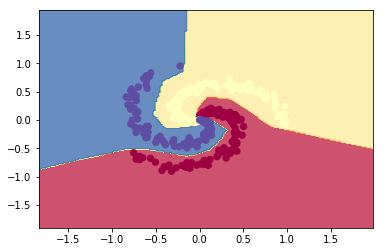

In [6]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

points = np.c_[xx.ravel(), yy.ravel()]
print(points.shape)

#forward prop with our trained parameters
_, Z = NN.forward_prop(points, trained_parameters)

# classify into highest prob
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

#plt the points
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
#fig.savefig('spiral_net.png')

## References

The code to generate the data I took from cs231n and this network is inspired from those course notes. Here are the links if you wish to check the notes yourself:

* http://cs231n.github.io/

* http://cs231n.github.io/neural-networks-case-study/